# KAN: Kolmogorov–Arnold Networks
## 樊豫龙 毛奕婷 黄颖 王一诺
## [引用]arXiv:2404.19756v2 [cs.LG] 2 May 2024
### Tips:
### 我们将KANLayer.py中的参数精度设置为64位，即FloatTensor改成了DoubleTensor

## Kolmogorov-Arnold表示定理
Kolmogorov-Arnold定理表明，如果$f$是一个定义在有界域上的多元连续函数，那么它可以被表示为单变量连续函数和加法的有限组合。更具体地说，对于一个光滑的函数，存在一系列单变量连续函数和加法操作，将其表示为有限次的组合。更详细的，可以表示为下列函数$f : [0,1]^n \to \mathbb{R}$：
$$f(x) = f(x_1,...,x_n)=\sum_{q=1}^{2n+1}\Phi_q(\sum_{p=1}^n \phi_{q,p}(x_p))$$
在这段文字中，提到了函数$\phi_{q,p}:[0,1]\to\mathbb{R}$ 和 $\Phi_q:\mathbb{R}\to\mathbb{R}$，从某种意义上说，他们表明唯一真正的多元函数是加法，因为每个其他函数都可以用单变量函数和求和来表示。然而，这种 2 层宽度为 (2n+1) 的Kolmogorov–Arnold表示可能由于其有限的表达能力而不平滑。我们通过将其概括到任意深度和宽度来增强其表达能力。

## Kolmogorov-Arnold Network
## KAN 网络

科尔莫戈洛夫-阿诺尔德表示可以用矩阵形式表示如下：

$$f(x)={\bf \Phi}_{\rm out}\circ{\bf \Phi}_{\rm in}\circ {\bf x}$$

其中

$${\bf \Phi}_{\rm in}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n}(\cdot) \\ \vdots & & \vdots \\ \phi_{2n+1,1}(\cdot) & \cdots & \phi_{2n+1,n}(\cdot) \end{pmatrix},\quad {\bf \Phi}_{\rm out}=\begin{pmatrix} \Phi_1(\cdot) & \cdots & \Phi_{2n+1}(\cdot)\end{pmatrix}$$

我们注意到 ${\bf \Phi}_{\rm in}$ 和 ${\bf \Phi}_{\rm out}$ 都是以下函数矩阵 ${\bf \Phi}$（具有 $n_{\rm in}$ 个输入和 $n_{\rm out}$ 个输出）的特殊情况，我们称之为科尔莫戈洛夫-阿诺尔德层：

$${\bf \Phi}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n_{\rm in}}(\cdot) \\ \vdots & & \vdots \\ \phi_{n_{\rm out},1}(\cdot) & \cdots & \phi_{n_{\rm out},n_{\rm in}}(\cdot) \end{pmatrix}$$

${\bf \Phi}_{\rm in}$ 对应于 $n_{\rm in}=n, n_{\rm out}=2n+1$，而 ${\bf \Phi}_{\rm out}$ 对应于 $n_{\rm in}=2n+1, n_{\rm out}=1$。

定义完层以后，我们可以通过堆叠层来构建科尔莫戈洛夫-阿诺尔德网络。假设我们有 $L$ 个层，第 $l$ 层 ${\bf \Phi}_l$ 的形状为 $(n_{l+1}, n_{l})$。那么整个网络为

$${\rm KAN}({\bf x})={\bf \Phi}_{L-1}\circ\cdots \circ{\bf \Phi}_1\circ{\bf \Phi}_0\circ {\bf x}$$

相比之下，多层感知机（Multi-Layer Perceptron）是由线性层 ${\bf W}_l$ 和非线性函数 $\sigma$ 交错组成的：

$${\rm MLP}({\bf x})={\bf W}_{L-1}\circ\sigma\circ\cdots\circ {\bf W}_1\circ\sigma\circ {\bf W}_0\circ {\bf x}$$

科尔莫戈洛夫-阿诺尔德网络（KAN）可以很容易地进行可视化。
(1) KAN只是一系列KAN层的堆叠。
(2) 每个KAN层可以被视为一个全连接层，其中每条边上放置了一个一维函数。



## 实现 KAN 网络

### spline.py
由于KAN网络使用spline b样条函数作为激活函数，那么首先实现spline样条函数

In [20]:
def B_batch(x, grid, k=0, extend=True, device='cpu'):
    '''
    在B样条基上评估x的值
    参数:
    -----
        x : 2D torch.tensor
            输入，形状为(样条数, 样本数)
        grid : 2D torch.tensor
            网格，形状为(样条数, 网格点数)
        k : int
            样条的分段多项式的阶数。
        extend : bool
            如果为True，在两端扩展k点。如果为False，不扩展（零边界条件）。默认为True
        device : str
            设备
    '''
    
    # x形状: (size, x); grid形状: (size, grid)
    def extend_grid(grid, k_extend=0):
        # 向左和向右补充k
        # grid形状: (批量, 网格)
        h = (grid[:, [-1]] - grid[:, [0]]) / (grid.shape[1] - 1)
        
        for i in range(k_extend):
            grid = torch.cat([grid[:, [0]] - h, grid], dim=1)
            grid = torch.cat([grid, grid[:, [-1]] + h], dim=1)
        grid = grid.to(device)
        return grid
    
    if extend == True:
        grid = extend_grid(grid, k_extend=k)
    
    grid = grid.unsqueeze(dim=2).to(device)
    x = x.unsqueeze(dim=1).to(device)
    
    if k == 0:
        value = (x >= grid[:, :-1]) * (x < grid[:, 1:])
    else:
        B_km1 = B_batch(x[:, 0], grid=grid[:, :, 0], k=k - 1, extend=False, device=device)
        value = (x - grid[:, :-(k + 1)]) / (grid[:, k:-1] - grid[:, :-(k + 1)]) * B_km1[:, :-1] + (
                    grid[:, k + 1:] - x) / (grid[:, k + 1:] - grid[:, 1:(-k)]) * B_km1[:, 1:]
    return value

def coef2curve(x_eval, grid, coef, k, device="cpu"):
    '''
    将B样条系数转换为B样条曲线。对B样条曲线上的x进行评估（将B_batch结果沿B样条基相加）。

    参数:
    -----
        x_eval : 2D torch.tensor
            形状为(样条数, 样本数)
        grid : 2D torch.tensor
            形状为(样条数, 网格点数)
        coef : 2D torch.tensor
            形状为(样条数, 系数参数数)。系数参数数 = 网格间隔数 + k
        k : int
            样条的分段多项式的阶数。
        device : str
            设备

    '''
    # x_eval: (size, batch), grid: (size, grid), coef: (size, coef)
    # coef: (size, coef), B_batch: (size, coef, batch), 对coef求和
    if coef.dtype != x_eval.dtype:
        coef = coef.to(x_eval.dtype)
    y_eval = torch.einsum('ij,ijk->ik', coef, B_batch(x_eval, grid, k, device=device))
    return y_eval

def curve2coef(x_eval, y_eval, grid, k, device="cpu"):
    '''
    使用最小二乘法将B样条曲线转换为B样条系数。
    参数:
    -----
        x_eval : 2D torch.tensor
            形状为(样条数, 样本数)
        y_eval : 2D torch.tensor
            形状为(样条数, 样本数)
        grid : 2D torch.tensor
            形状为(样条数, 网格点数)
        k : int
            样条的分段多项式的阶数。
        device : str
            设备

    '''
    # x_eval: (size, batch); y_eval: (size, batch); grid: (size, grid); k: 标量
    mat = B_batch(x_eval, grid, k, device=device).permute(0, 2, 1)
    # 使用不同的算法解决最小二乘问题根据设备类型选择
    coef = torch.linalg.lstsq(mat.to(device), y_eval.unsqueeze(dim=2).to(device),
                              driver='gelsy' if device == 'cpu' else 'gels').solution[:, :, 0]
    return coef.to(device)


### KANLayer.py
定义了KAN模型中使用的自定义层，包括模型的核心组件，如特殊的激活层或其他处理层，这些是构成KAN的基础。

In [21]:
import torch
import torch.nn as nn

class KANLayer(nn.Module):
    """
    KANLayer 类
    属性:
    ----
        in_dim: int
            输入维度
        out_dim: int
            输出维度
        size: int
            样条曲线的数量 = 输入维度 * 输出维度
        k: int
            样条的分段多项式阶数
        grid: 2D torch.float
            网格点
        noises: 2D torch.float
            初始化时注入的噪声以打破退化(degeneracy)
        coef: 2D torch.tensor
            B样条基的系数
        scale_base: 1D torch.float
            残差函数b(x)的幅度
        scale_sp: 1D torch.float
            样条函数spline(x)的幅度
        base_fun: fun
            残差函数b(x)
        mask: 1D torch.float
            样条函数的掩码。将掩码的某些元素设置为零意味着将相应的激活设置为零函数。
        grid_eps: float in [0,1]
            用于基于样本的激活更新网格的超参数。当grid_eps = 0时，网格是均匀的；当grid_eps = 1时，网格使用样本的百分位数进行划分。0 < grid_eps < 1在两个极端之间插值。
        weight_sharing: 1D tensor int
            允许样条激活共享参数
        lock_counter: int
            记录多少个激活函数被锁定（参数共享）
        lock_id: 1D torch.int
            被锁定激活函数的id
        device: str
            设备

    方法:
    -----
        __init__():
            初始化KANLayer
        forward():
            前向传播
        update_grid_from_samples():
            基于样本的激活更新网格
        initialize_grid_from_parent():
            从另一个模型初始化网格
        get_subset():
            获取KANLayer的子集（用于剪枝）
        lock():
            锁定几个激活函数以共享参数
        unlock():
            解锁已经锁定的激活函数
    """ 
    def __init__(self, in_dim=3, out_dim=2, num=5, k=3, noise_scale=0.1, 
                 scale_base=1.0, scale_sp=1.0, 
                 base_fun=torch.nn.SiLU(), grid_eps=0.02, grid_range=[-1, 1], 
                 sp_trainable=True, 
                 sb_trainable=True, device='cpu'):
        '''初始化一个KANLayer
        参数：
        -----
            in_dim : int
                输入维度。默认值：2。
            out_dim : int
                输出维度。默认值：3。
            num : int
                网格间隔的数量 = G。默认值：5。
            k : int
                分段多项式的阶数。默认值：3。
            noise_scale : float
                初始化时注入的噪声的尺度。默认值：0.1。
            scale_base : float
                残差函数 b(x) 的尺度。默认值：1.0。
            scale_sp : float
                基础函数 spline(x) 的尺度。默认值：1.0。
            base_fun : function
                残差函数 b(x)。默认值：torch.nn.SiLU()
            grid_eps : float
                当 grid_eps = 0 时，网格是均匀分布的；当 grid_eps = 1 时，网格使用样本的百分位数进行划分。0 < grid_eps < 1 在两个极端之间插值。默认值：0.02。
            grid_range : list/np.array of shape (2,)
                设置网格的范围。默认值：[-1,1]。
            sp_trainable : bool
                如果为True，则scale_sp可训练。默认值：True。
            sb_trainable : bool
                如果为True，则scale_base可训练。默认值：True。
            device : str
                设备
        '''
        super(KANLayer, self).__init__()
        # size 
        self.size = size = out_dim * in_dim
        self.out_dim = out_dim
        self.in_dim = in_dim
        self.num = num
        self.k = k
        
        # shape: (size, num)
        self.grid = torch.einsum('i,j->ij', torch.ones(size, device=device), torch.linspace(grid_range[0], grid_range[1], steps=num + 1, device=device))
        self.grid = torch.nn.Parameter(self.grid).requires_grad_(False)
        noises = (torch.rand(size, self.grid.shape[1]) - 1 / 2) * noise_scale / num
        noises = noises.to(device)
        # shape: (size, coef)
        self.coef = torch.nn.Parameter(curve2coef(self.grid, noises, self.grid, k, device))
        if isinstance(scale_base, float):
            self.scale_base = torch.nn.Parameter(torch.ones(size, device=device) * scale_base).requires_grad_(sb_trainable)  # make scale trainable
        else:
            self.scale_base = torch.nn.Parameter(torch.DoubleTensor(scale_base).to(device)).requires_grad_(sb_trainable)
        self.scale_sp = torch.nn.Parameter(torch.ones(size, device=device) * scale_sp).requires_grad_(sp_trainable)  # make scale trainable
        self.base_fun = base_fun
    
        self.mask = torch.nn.Parameter(torch.ones(size, device=device)).requires_grad_(False)
        self.grid_eps = grid_eps
        self.weight_sharing = torch.arange(size)
        self.lock_counter = 0
        self.lock_id = torch.zeros(size)
        self.device = device
    
    def forward(self, x):
        """
        KANLayer根据输入x进行前向传播
        
        参数:
        -----
            x : 2D torch.float
                输入数据，形状为 (样本数, 输入维度)
        
        返回:
        --------
            y : 2D torch.float
                输出数据，形状为 (样本数, 输出维度)
            preacts : 3D torch.float
                将x展开到激活函数的激活值，形状为 (样本数, 输出维度, 输入维度)
            postacts : 3D torch.float
                激活函数输出值，以preacts为输入
            postspline : 3D torch.float
                样条函数输出值，以preacts为输入
        """
        batch = x.shape[0]
        # x形状: (批次数, 输入维度) => 形状 (大小, 批次数) (大小 = 输出维度 * 输入维度)
        x = torch.einsum('ij,k->ikj', x, torch.ones(self.out_dim, device=self.device)).reshape(batch, self.size).permute(1, 0)
        preacts = x.permute(1, 0).clone().reshape(batch, self.out_dim, self.in_dim)
        base = self.base_fun(x).permute(1, 0)  # 形状 (批次数, 大小)
        # 使用样条转换函数coef2curve计算输出y，形状(size, 批次数)
        y = coef2curve(x_eval=x, grid=self.grid[self.weight_sharing], coef=self.coef[self.weight_sharing], k=self.k, device=self.device)
        y = y.permute(1, 0)  # 形状 (批次数, 大小)
        postspline = y.clone().reshape(batch, self.out_dim, self.in_dim)
        # 结果y通过应用缩放因子和遮罩进行调整
        y = self.scale_base.unsqueeze(dim=0) * base + self.scale_sp.unsqueeze(dim=0) * y
        y = self.mask[None, :] * y
        postacts = y.clone().reshape(batch, self.out_dim, self.in_dim)
        y = torch.sum(y.reshape(batch, self.out_dim, self.in_dim), dim=2)  # 形状 (批次数, 输出维度)
        
        # 返回结果
        return y, preacts, postacts, postspline
        
    def update_grid_from_samples(self, x):
        """
        根据样本更新网格
        
        参数:
        ----
        x : 2D torch.float
            输入，形状为(样本数量, 输入维度)
        """
        batch = x.shape[0]
        x = torch.einsum('ij,k->ikj', x, torch.ones(self.out_dim, ).to(self.device)).reshape(batch, self.size).permute(1, 0)
        x_pos = torch.sort(x, dim=1)[0]
        y_eval = coef2curve(x_pos, self.grid, self.coef, self.k, device=self.device)
        num_interval = self.grid.shape[1] - 1
        ids = [int(batch / num_interval * i) for i in range(num_interval)] + [-1]
        grid_adaptive = x_pos[:, ids]
        margin = 0.01
        grid_uniform = torch.cat([grid_adaptive[:, [0]] - margin + (grid_adaptive[:, [-1]] - grid_adaptive[:, [0]] + 2 * margin) * a for a in np.linspace(0, 1, num=self.grid.shape[1])], dim=1)
        self.grid.data = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        self.coef.data = curve2coef(x_pos, y_eval, self.grid, self.k, device=self.device)
        
    def initialize_grid_from_parent(self, parent, x):
        '''
        从父KANLayer和样本中更新网格
        
        参数:
        ------
            parent : KANLayer
                父KANLayer（其网格通常比当前模型粗）
            x : 2D torch.float
                输入样本，形状为（样本数量，输入维度）
        '''
        batch = x.shape[0]
        # preacts: 形状为 (batch, in_dim) => 形状为 (size, batch) (size = out_dim * in_dim)
        x_eval = torch.einsum('ij,k->ikj', x, torch.ones(self.out_dim, ).to(self.device)).reshape(batch, self.size).permute(1, 0)
        x_pos = parent.grid
        sp2 = KANLayer(in_dim=1, out_dim=self.size, k=1, num=x_pos.shape[1] - 1, scale_base=0., device=self.device)
        sp2.coef.data = curve2coef(sp2.grid, x_pos, sp2.grid, k=1, device=self.device)
        y_eval = coef2curve(x_eval, parent.grid, parent.coef, parent.k, device=self.device)
        percentile = torch.linspace(-1, 1, self.num + 1).to(self.device)
        self.grid.data = sp2(percentile.unsqueeze(dim=1))[0].permute(1, 0)
        self.coef.data = curve2coef(x_eval, y_eval, self.grid, self.k, self.device)
                
    def get_subset(self, in_id, out_id):
        '''
        从较大的KANLayer中获取一个较小的KANLayer（用于剪枝），以减少网络的复杂性或者提高计入的效率
        
        参数:
        ------
            in_id : list
                选择的输入神经元的ID列表
            out_id : list
                选择的输出神经元的ID列表
            
        返回:
        ------
            spb : KANLayer
        '''
        spb = KANLayer(len(in_id), len(out_id), self.num, self.k, base_fun=self.base_fun, device=self.device)
        spb.grid.data = self.grid.reshape(self.out_dim, self.in_dim, spb.num + 1)[out_id][:, in_id].reshape(-1, spb.num + 1)
        spb.coef.data = self.coef.reshape(self.out_dim, self.in_dim, spb.coef.shape[1])[out_id][:, in_id].reshape(-1, spb.coef.shape[1])
        spb.scale_base.data = self.scale_base.reshape(self.out_dim, self.in_dim)[out_id][:, in_id].reshape(-1, )
        spb.scale_sp.data = self.scale_sp.reshape(self.out_dim, self.in_dim)[out_id][:, in_id].reshape(-1, )
        spb.mask.data = self.mask.reshape(self.out_dim, self.in_dim)[out_id][:, in_id].reshape(-1, )

        spb.in_dim = len(in_id)
        spb.out_dim = len(out_id)
        spb.size = spb.in_dim * spb.out_dim
        return spb
            
    def lock(self, ids):
        '''
        根据 ids 锁定激活函数以共享参数
    
        参数:
        -----
            ids : list
                激活函数的 id 列表
        '''
        self.lock_counter += 1
        # ids: [[i1,j1],[i2,j2],[i3,j3],...]
        for i in range(len(ids)):
            if i != 0:
                # 根据第一个 id 更改其他id对应的激活函数的参数共享指向
                self.weight_sharing[ids[i][1] * self.in_dim + ids[i][0]] = ids[0][1] * self.in_dim + ids[0][0]
            # 为每个 id 分配锁定计数器，用于后续的参数共享判断
            self.lock_id[ids[i][1] * self.in_dim + ids[i][0]] = self.lock_counter
            
    def unlock(self, ids):
        '''
        解锁激活函数
        
        参数:
        -----
            ids : list
                激活函数的id列表
                 [6, 7, 8]])
        '''
        # 检查 ids 是否已锁定
        num = len(ids)
        locked = True
        for i in range(num):
            locked *= (self.weight_sharing[ids[i][1] * self.in_dim + ids[i][0]] == self.weight_sharing[ids[0][1] * self.in_dim + ids[0][0]])
        if locked == False:
            print("这些激活函数没有锁定。解锁失败。")
            return 0
        for i in range(len(ids)):
            # 将权重共享索引重置为默认状态
            self.weight_sharing[ids[i][1] * self.in_dim + ids[i][0]] = ids[i][1] * self.in_dim + ids[i][0]
            # 重置锁定标识
            self.lock_id[ids[i][1] * self.in_dim + ids[i][0]] = 0
        # 减少锁定计数器
        self.lock_counter -= 1
        

### utils.py
数学和符号计算框架

In [22]:
import sympy
from sklearn.linear_model import LinearRegression

# 初始化一些符号库
SYMBOLIC_LIB = {
    'x': (lambda x: x, lambda x: x),
    'x^2': (lambda x: x**2, lambda x: x**2),
    'x^3': (lambda x: x**3, lambda x: x**3),
    'x^4': (lambda x: x**4, lambda x: x**4),
    '1/x': (lambda x: 1/x, lambda x: 1/x),
    '1/x^2': (lambda x: 1/x**2, lambda x: 1/x**2),
    '1/x^3': (lambda x: 1/x**3, lambda x: 1/x**3),
    '1/x^4': (lambda x: 1/x**4, lambda x: 1/x**4),
    'sqrt': (lambda x: torch.sqrt(x), lambda x: sympy.sqrt(x)),
    '1/sqrt(x)': (lambda x: 1/torch.sqrt(x), lambda x: 1/sympy.sqrt(x)),
    'exp': (lambda x: torch.exp(x), lambda x: sympy.exp(x)),
    'log': (lambda x: torch.log(x), lambda x: sympy.log(x)),
    'abs': (lambda x: torch.abs(x), lambda x: sympy.Abs(x)),
    'sin': (lambda x: torch.sin(x), lambda x: sympy.sin(x)),
    'tan': (lambda x: torch.tan(x), lambda x: sympy.tan(x)),
    'tanh': (lambda x: torch.tanh(x), lambda x: sympy.tanh(x)),
    'sigmoid': (lambda x: torch.sigmoid(x), sympy.Function('sigmoid')),
    'sgn': (lambda x: torch.sign(x), lambda x: sympy.sign(x)),
    'arcsin': (lambda x: torch.arcsin(x), lambda x: sympy.arcsin(x)),
    'arctan': (lambda x: torch.arctan(x), lambda x: sympy.atan(x)),
    'arctanh': (lambda x: torch.arctanh(x), lambda x: sympy.atanh(x)),
    '0': (lambda x: x*0, lambda x: x*0),
    'gaussian': (lambda x: torch.exp(-x**2), lambda x: sympy.exp(-x**2)),
    'cosh': (lambda x: torch.cosh(x), lambda x: sympy.cosh(x)),
}

def create_dataset(f, 
                   n_var=2, 
                   ranges = [-1,1],
                   train_num=1000, 
                   test_num=1000,
                   normalize_input=False,
                   normalize_label=False,
                   device='cpu',
                   seed=0):
    '''
    创建数据集
    
    参数:
    -----
        f : function
            创建合成数据集所使用的符号公式
        ranges : list or np.array; shape (2,) or (n_var, 2)
            输入变量的范围，默认为 [-1,1]。
        train_num : int
            训练样本数量，默认为 1000。
        test_num : int
            测试样本数量，默认为 1000。
        normalize_input : bool
            如果为 True，则对输入应用标准化，默认为 False。
        normalize_label : bool
            如果为 True，则对标签应用标准化，默认为 False。
        device : str
            设备，默认为 'cpu'。
        seed : int
            随机种子，默认为 0。

    返回:
    --------
        dataset : dic
            Train/test inputs/labels are dataset['train_input'], dataset['train_label'],
                        dataset['test_input'], dataset['test_label']
    '''
    np.random.seed(seed)
    torch.manual_seed(seed)

    if len(np.array(ranges).shape) == 1:
        ranges = np.array(ranges * n_var).reshape(n_var, 2)
    else:
        ranges = np.array(ranges)
        
    train_input = torch.zeros(train_num, n_var)
    test_input = torch.zeros(test_num, n_var)
    for i in range(n_var):
        train_input[:, i] = torch.rand(train_num,) * (ranges[i, 1] - ranges[i, 0]) + ranges[i, 0]
        test_input[:, i] = torch.rand(test_num,) * (ranges[i, 1] - ranges[i, 0]) + ranges[i, 0]
                  
    train_label = f(train_input)
    test_label = f(test_input)
                  
    def normalize(data, mean, std):
        '''
        将数据标准化

        参数:
        -----
            data : 数据
            mean : 均值
            std : 标准差

        返回:
        ------
            标准化后的数据
        '''
        return (data - mean) / std
                 
    if normalize_input == True:
        mean_input = torch.mean(train_input, dim=0, keepdim=True)
        std_input = torch.std(train_input, dim=0, keepdim=True)
        train_input = normalize(train_input, mean_input, std_input)
        test_input = normalize(test_input, mean_input, std_input)
                 
    if normalize_label == True:
        mean_label = torch.mean(train_label, dim=0, keepdim=True)
        std_label = torch.std(train_label, dim=0, keepdim=True)
        train_label = normalize(train_label, mean_label, std_label)
        test_label = normalize(test_label, mean_label, std_label)
 
    dataset = {
        'train_input': train_input.to(device),
        'test_input': test_input.to(device),
        'train_label': train_label.to(device),
        'test_label': test_label.to(device),
    }
 
    return dataset
def fit_params(x, y, fun, a_range=(-10,10), b_range=(-10,10), grid_number=101, iteration=3, verbose=True, device='cpu'):
    '''
    根据给定函数 fun 调整参数 a, b, c, d ，使得以下公式最小化：
          .. math::
         |y-(cf(ax+b)+d)|^2
    其中 x 和 y 都是一维数组。沿 a 和 b 进行扫描，找到最佳拟合的模型。
          参数:
    -----
         x : 1D array
             x 的值
         y : 1D array
             y 的值
         fun : function
             符号函数
         a_range : tuple
             a 的扫描范围
         b_range : tuple
             b 的扫描范围
         grid_num : int
             a 和 b 沿其范围内的步数
         iteration : int
             放大倍数
         verbose : bool
             如果为 True，则打印额外信息
         device : str
             设备
          返回值:
    --------
         a_best : float
             最佳拟合 a 的值
         b_best : float
             最佳拟合 b 的值
         c_best : float
             最佳拟合 c 的值
         d_best : float
             最佳拟合 d 的值
         r2_best : float
             最佳 r2 值（决定系数）
          示例
    -------
     >>> num = 100
     >>> x = torch.linspace(-1,1,steps=num)
     >>> noises = torch.normal(0,1,(num,)) * 0.02
     >>> y = 5.0*torch.sin(3.0*x + 2.0) + 0.7 + noises
     >>> fit_params(x, y, torch.sin)
     r2 为 0.9999727010726929
     (tensor([2.9982, 1.9996, 5.0053, 0.7011]), tensor(1.0000))
    '''
    
    for _ in range(iteration):
        a_ = torch.linspace(a_range[0], a_range[1], steps=grid_number, device=device)
        b_ = torch.linspace(b_range[0], b_range[1], steps=grid_number, device=device)
        a_grid, b_grid = torch.meshgrid(a_, b_, indexing='ij')
        post_fun = fun(a_grid[None,:,:] * x[:,None,None] + b_grid[None,:,:])
        x_mean = torch.mean(post_fun, dim=[0], keepdim=True)
        y_mean = torch.mean(y, dim=[0], keepdim=True)
        numerator = torch.sum((post_fun - x_mean)*(y-y_mean)[:,None,None], dim=0)**2
        denominator = torch.sum((post_fun - x_mean)**2, dim=0)*torch.sum((y - y_mean)[:,None,None]**2, dim=0)
        r2 = numerator / (denominator + 1e-4)
        r2 = torch.nan_to_num(r2)

        best_id = torch.argmax(r2)
        a_id, b_id = torch.div(best_id, grid_number, rounding_mode='floor'), best_id % grid_number

        if a_id == 0 or a_id == grid_number - 1 or b_id == 0 or b_id == grid_number - 1:
            if _ == 0 and verbose == True:
                print('最佳值位于边界。')
            if a_id == 0:
                a_arange = [a_[0], a_[1]]
            if a_id == grid_number - 1:
                a_arange = [a_[-2], a_[-1]]
            if b_id == 0:
                b_arange = [b_[0], b_[1]]
            if b_id == grid_number - 1:
                b_arange = [b_[-2], b_[-1]]

        else:
            a_range = [a_[a_id-1], a_[a_id+1]]
            b_range = [b_[b_id-1], b_[b_id+1]]

    a_best = a_[a_id]
    b_best = b_[b_id]
    post_fun = fun(a_best * x + b_best)
    r2_best = r2[a_id, b_id]

    if verbose == True:
        print(f"r2 为 {r2_best}")
        if r2_best < 0.9:
            print(f'r2 值不是很高，请检查你是否选择了正确的符号函数。')

    post_fun = torch.nan_to_num(post_fun)
    reg = LinearRegression().fit(post_fun[:, None].detach().cpu().numpy(), y.detach().cpu().numpy())
    c_best = torch.from_numpy(reg.coef_)[0].to(device)
    d_best = torch.from_numpy(np.array(reg.intercept_)).to(device)
    return torch.stack([a_best, b_best, c_best, d_best]), r2_best

def add_symbolic(name, fun):
    '''
    向库中添加符号函数
    
    参数:
    -----
        name : str
            函数名称
        fun : fun
            Torch函数或lambda函数
    '''
    exec(f"globals()['{name}'] = sympy.Function('{name}')")
    SYMBOLIC_LIB[name] = (fun, globals()[name])


### Symbolic_KANLayer.py
实现了一种特殊的KAN层，用于处理符号计算或增强模型的解释性。将数据或激活函数转换为符号形式，以便进行更深入的分析或解释。

In [23]:
import torch
import torch.nn as nn
import numpy as np
import sympy

class Symbolic_KANLayer(nn.Module):
    '''
    KANLayer 类

    属性:
    -------
        in_dim: int
            输入维度
        out_dim: int
            输出维度
        funs: 2D 数组，元素为 torch 函数或 lambda 函数
            符号函数（torch）
        funs_name: 2D 数组，元素为字符串
            符号函数的名称
        funs_sympy: 2D 数组，元素为 sympy 函数或 lambda 函数
            符号函数（sympy）
        affine: 3D 浮点数组
            输入和输出的仿射变换参数

    方法:
    -------
        __init__():
            初始化 Symbolic_KANLayer
        forward():
            前向计算方法
        get_subset():
            获取 KANLayer 的子集（用于剪枝）
        fix_symbolic():
            将激活函数固定为符号函数
    '''
    
    def __init__(self, in_dim=3, out_dim=2, device='cpu'):
        '''
        初始化 Symbolic_KANLayer（激活函数初始化为恒等函数）

        参数:
        -----
            in_dim : int
                输入维度
            out_dim : int
                输出维度
            device : str
                设备

        返回:
        --------
            self

        '''
        super(Symbolic_KANLayer, self).__init__()
        self.out_dim = out_dim
        self.in_dim = in_dim
        self.mask = torch.nn.Parameter(torch.zeros(out_dim, in_dim, device=device)).requires_grad_(False)
        # torch
        self.funs = [[lambda x: x for i in range(self.in_dim)] for j in range(self.out_dim)]
        # name
        self.funs_name = [['' for i in range(self.in_dim)] for j in range(self.out_dim)]
        # sympy
        self.funs_sympy = [['' for i in range(self.in_dim)] for j in range(self.out_dim)]

        self.affine = torch.nn.Parameter(torch.zeros(out_dim, in_dim, 4, device=device))
        # c*f(a*x+b)+d

        self.device = device

    def forward(self, x):
        '''
        前向计算方法

        参数:
        -----
            x : 2D 数组
                输入，形状 (batch, 输入维度)

        返回:
        --------
            y : 2D 数组
                输出，形状 (batch, 输出维度)
            postacts : 3D 数组
                激活函数之后但在节点上求和之前的激活值


        '''

        batch = x.shape[0]
        postacts = []

        for i in range(self.in_dim):
            postacts_ = []
            for j in range(self.out_dim):
                xij = self.affine[j,i,2]*self.funs[j][i](self.affine[j,i,0]*x[:,[i]]+self.affine[j,i,1])+self.affine[j,i,3]
                postacts_.append(self.mask[j][i]*xij)
            postacts.append(torch.stack(postacts_))

        postacts = torch.stack(postacts)
        postacts = postacts.permute(2,1,0,3)[:,:,:,0]
        y = torch.sum(postacts, dim=2)

        return y, postacts
    
    def get_subset(self, in_id, out_id):
        '''
        从一个更大的 Symbolic_KANLayer 中获取一个更小的 Symbolic_KANLayer（用于修剪）
        
        参数:
        -----
            in_id : list
                选定输入神经元的 id
            out_id : list
                选定输出神经元的 id
                 
        返回值:
        --------
            spb : Symbolic_KANLayer
        
        '''
        sbb = Symbolic_KANLayer(self.in_dim, self.out_dim, device=self.device)
        sbb.in_dim = len(in_id)
        sbb.out_dim = len(out_id)
        sbb.mask.data = self.mask.data[out_id][:,in_id]
        sbb.funs = [[self.funs[j][i] for i in in_id] for j in out_id]
        sbb.funs_sympy = [[self.funs_sympy[j][i] for i in in_id] for j in out_id]
        sbb.funs_name = [[self.funs_name[j][i] for i in in_id] for j in out_id]
        sbb.affine.data = self.affine.data[out_id][:,in_id]
        return sbb

    def fix_symbolic(self, i, j, fun_name, x=None, y=None, random=False, a_range=(-10,10), b_range=(-10,10), verbose=True):
        '''
        将激活函数固定为符号函数
        
        参数:
        -----
            i : int
                输入神经元的 id
            j : int
                输出神经元的 id
            fun_name : str
                符号函数的名称
            x : 1D array
                预激活值
            y : 1D array
                后激活值
            a_range : tuple
                a 的扫描范围
            b_range : tuple
                a 的扫描范围
            verbose : bool
                若为 True，则打印更多信息
                
        返回值:
        --------
            r2（决定系数）
    
        '''
        if isinstance(fun_name,str):
            fun = SYMBOLIC_LIB[fun_name][0]
            fun_sympy = SYMBOLIC_LIB[fun_name][1]
            self.funs_sympy[j][i] = fun_sympy
            self.funs_name[j][i] = fun_name
            if x == None or y == None:
                # 仅从函数初始化
                self.funs[j][i] = fun
                if random == False:
                    self.affine.data[j][i] = torch.tensor([1.,0.,1.,0.])
                else:
                    self.affine.data[j][i] = torch.rand(4,) * 2 - 1
                return None
            else:
                # 根据 x & y 和函数初始化
                params, r2 = fit_params(x, y, fun, a_range=a_range, b_range=b_range, verbose=verbose, device=self.device)
                self.funs[j][i] = fun
                self.affine.data[j][i] = params
                return r2
        else:
            # 如果 fun_name 本身就是一个函数
            fun = fun_name
            fun_sympy = fun_name
            self.funs_sympy[j][i] = fun_sympy
            self.funs_name[j][i] = "匿名"
            
            self.funs[j][i] = fun
            if random == False:
                self.affine.data[j][i] = torch.tensor([1.,0.,1.,0.])
            else:
                self.affine.data[j][i] = torch.rand(4,) * 2 - 1
            return None



### LBFGS.py
包含了适用于KANs训练的L-BFGS优化器的实现

In [24]:
import torch
from functools import reduce
from torch.optim import Optimizer

__all__ = ['LBFGS']

def _cubic_interpolate(x1, f1, g1, x2, f2, g2, bounds=None):
    # ported from https://github.com/torch/optim/blob/master/polyinterp.lua
    # Compute bounds of interpolation area
    if bounds is not None:
        xmin_bound, xmax_bound = bounds
    else:
        xmin_bound, xmax_bound = (x1, x2) if x1 <= x2 else (x2, x1)

    # Code for most common case: cubic interpolation of 2 points
    #   w/ function and derivative values for both
    # Solution in this case (where x2 is the farthest point):
    #   d1 = g1 + g2 - 3*(f1-f2)/(x1-x2);
    #   d2 = sqrt(d1^2 - g1*g2);
    #   min_pos = x2 - (x2 - x1)*((g2 + d2 - d1)/(g2 - g1 + 2*d2));
    #   t_new = min(max(min_pos,xmin_bound),xmax_bound);
    d1 = g1 + g2 - 3 * (f1 - f2) / (x1 - x2)
    d2_square = d1**2 - g1 * g2
    if d2_square >= 0:
        d2 = d2_square.sqrt()
        if x1 <= x2:
            min_pos = x2 - (x2 - x1) * ((g2 + d2 - d1) / (g2 - g1 + 2 * d2))
        else:
            min_pos = x1 - (x1 - x2) * ((g1 + d2 - d1) / (g1 - g2 + 2 * d2))
        return min(max(min_pos, xmin_bound), xmax_bound)
    else:
        return (xmin_bound + xmax_bound) / 2.


def _strong_wolfe(obj_func,
                  x,
                  t,
                  d,
                  f,
                  g,
                  gtd,
                  c1=1e-4,
                  c2=0.9,
                  tolerance_change=1e-9,
                  max_ls=25):
    # ported from https://github.com/torch/optim/blob/master/lswolfe.lua
    d_norm = d.abs().max()
    g = g.clone(memory_format=torch.contiguous_format)
    # evaluate objective and gradient using initial step
    f_new, g_new = obj_func(x, t, d)
    ls_func_evals = 1
    gtd_new = g_new.dot(d)

    # bracket an interval containing a point satisfying the Wolfe criteria
    t_prev, f_prev, g_prev, gtd_prev = 0, f, g, gtd
    done = False
    ls_iter = 0
    while ls_iter < max_ls:
        # check conditions
        if f_new > (f + c1 * t * gtd) or (ls_iter > 1 and f_new >= f_prev):
            bracket = [t_prev, t]
            bracket_f = [f_prev, f_new]
            bracket_g = [g_prev, g_new.clone(memory_format=torch.contiguous_format)]
            bracket_gtd = [gtd_prev, gtd_new]
            break

        if abs(gtd_new) <= -c2 * gtd:
            bracket = [t]
            bracket_f = [f_new]
            bracket_g = [g_new]
            done = True
            break

        if gtd_new >= 0:
            bracket = [t_prev, t]
            bracket_f = [f_prev, f_new]
            bracket_g = [g_prev, g_new.clone(memory_format=torch.contiguous_format)]
            bracket_gtd = [gtd_prev, gtd_new]
            break

        # interpolate
        min_step = t + 0.01 * (t - t_prev)
        max_step = t * 10
        tmp = t
        t = _cubic_interpolate(
            t_prev,
            f_prev,
            gtd_prev,
            t,
            f_new,
            gtd_new,
            bounds=(min_step, max_step))

        # next step
        t_prev = tmp
        f_prev = f_new
        g_prev = g_new.clone(memory_format=torch.contiguous_format)
        gtd_prev = gtd_new
        f_new, g_new = obj_func(x, t, d)
        ls_func_evals += 1
        gtd_new = g_new.dot(d)
        ls_iter += 1

    # reached max number of iterations?
    if ls_iter == max_ls:
        bracket = [0, t]
        bracket_f = [f, f_new]
        bracket_g = [g, g_new]

    # zoom phase: we now have a point satisfying the criteria, or
    # a bracket around it. We refine the bracket until we find the
    # exact point satisfying the criteria
    insuf_progress = False
    # find high and low points in bracket
    low_pos, high_pos = (0, 1) if bracket_f[0] <= bracket_f[-1] else (1, 0)
    while not done and ls_iter < max_ls:
        # line-search bracket is so small
        if abs(bracket[1] - bracket[0]) * d_norm < tolerance_change:
            break

        # compute new trial value
        t = _cubic_interpolate(bracket[0], bracket_f[0], bracket_gtd[0],
                               bracket[1], bracket_f[1], bracket_gtd[1])

        # test that we are making sufficient progress:
        # in case `t` is so close to boundary, we mark that we are making
        # insufficient progress, and if
        #   + we have made insufficient progress in the last step, or
        #   + `t` is at one of the boundary,
        # we will move `t` to a position which is `0.1 * len(bracket)`
        # away from the nearest boundary point.
        eps = 0.1 * (max(bracket) - min(bracket))
        if min(max(bracket) - t, t - min(bracket)) < eps:
            # interpolation close to boundary
            if insuf_progress or t >= max(bracket) or t <= min(bracket):
                # evaluate at 0.1 away from boundary
                if abs(t - max(bracket)) < abs(t - min(bracket)):
                    t = max(bracket) - eps
                else:
                    t = min(bracket) + eps
                insuf_progress = False
            else:
                insuf_progress = True
        else:
            insuf_progress = False

        # Evaluate new point
        f_new, g_new = obj_func(x, t, d)
        ls_func_evals += 1
        gtd_new = g_new.dot(d)
        ls_iter += 1

        if f_new > (f + c1 * t * gtd) or f_new >= bracket_f[low_pos]:
            # Armijo condition not satisfied or not lower than lowest point
            bracket[high_pos] = t
            bracket_f[high_pos] = f_new
            bracket_g[high_pos] = g_new.clone(memory_format=torch.contiguous_format)
            bracket_gtd[high_pos] = gtd_new
            low_pos, high_pos = (0, 1) if bracket_f[0] <= bracket_f[1] else (1, 0)
        else:
            if abs(gtd_new) <= -c2 * gtd:
                # Wolfe conditions satisfied
                done = True
            elif gtd_new * (bracket[high_pos] - bracket[low_pos]) >= 0:
                # old low becomes new high
                bracket[high_pos] = bracket[low_pos]
                bracket_f[high_pos] = bracket_f[low_pos]
                bracket_g[high_pos] = bracket_g[low_pos]
                bracket_gtd[high_pos] = bracket_gtd[low_pos]

            # new point becomes new low
            bracket[low_pos] = t
            bracket_f[low_pos] = f_new
            bracket_g[low_pos] = g_new.clone(memory_format=torch.contiguous_format)
            bracket_gtd[low_pos] = gtd_new

    # return stuff
    t = bracket[low_pos]
    f_new = bracket_f[low_pos]
    g_new = bracket_g[low_pos]
    return f_new, g_new, t, ls_func_evals



class LBFGS(Optimizer):
    """Implements L-BFGS algorithm.

    Heavily inspired by `minFunc
    <https://www.cs.ubc.ca/~schmidtm/Software/minFunc.html>`_.

    .. warning::
        This optimizer doesn't support per-parameter options and parameter
        groups (there can be only one).

    .. warning::
        Right now all parameters have to be on a single device. This will be
        improved in the future.

    .. note::
        This is a very memory intensive optimizer (it requires additional
        ``param_bytes * (history_size + 1)`` bytes). If it doesn't fit in memory
        try reducing the history size, or use a different algorithm.

    Args:
        lr (float): learning rate (default: 1)
        max_iter (int): maximal number of iterations per optimization step
            (default: 20)
        max_eval (int): maximal number of function evaluations per optimization
            step (default: max_iter * 1.25).
        tolerance_grad (float): termination tolerance on first order optimality
            (default: 1e-7).
        tolerance_change (float): termination tolerance on function
            value/parameter changes (default: 1e-9).
        history_size (int): update history size (default: 100).
        line_search_fn (str): either 'strong_wolfe' or None (default: None).
    """

    def __init__(self,
                 params,
                 lr=1,
                 max_iter=20,
                 max_eval=None,
                 tolerance_grad=1e-7,
                 tolerance_change=1e-9,
                 tolerance_ys=1e-32,
                 history_size=100,
                 line_search_fn=None):
        if max_eval is None:
            max_eval = max_iter * 5 // 4
        defaults = dict(
            lr=lr,
            max_iter=max_iter,
            max_eval=max_eval,
            tolerance_grad=tolerance_grad,
            tolerance_change=tolerance_change,
            tolerance_ys=tolerance_ys,
            history_size=history_size,
            line_search_fn=line_search_fn)
        super().__init__(params, defaults)

        if len(self.param_groups) != 1:
            raise ValueError("LBFGS doesn't support per-parameter options "
                             "(parameter groups)")

        self._params = self.param_groups[0]['params']
        self._numel_cache = None

    def _numel(self):
        if self._numel_cache is None:
            self._numel_cache = reduce(lambda total, p: total + p.numel(), self._params, 0)
        return self._numel_cache

    def _gather_flat_grad(self):
        views = []
        for p in self._params:
            if p.grad is None:
                view = p.new(p.numel()).zero_()
            elif p.grad.is_sparse:
                view = p.grad.to_dense().view(-1)
            else:
                view = p.grad.view(-1)
            views.append(view)
        return torch.cat(views, 0)

    def _add_grad(self, step_size, update):
        offset = 0
        for p in self._params:
            numel = p.numel()
            # view as to avoid deprecated pointwise semantics
            p.add_(update[offset:offset + numel].view_as(p), alpha=step_size)
            offset += numel
        assert offset == self._numel()

    def _clone_param(self):
        return [p.clone(memory_format=torch.contiguous_format) for p in self._params]

    def _set_param(self, params_data):
        for p, pdata in zip(self._params, params_data):
            p.copy_(pdata)

    def _directional_evaluate(self, closure, x, t, d):
        self._add_grad(t, d)
        loss = float(closure())
        flat_grad = self._gather_flat_grad()
        self._set_param(x)
        return loss, flat_grad


    @torch.no_grad()
    def step(self, closure):
        """Perform a single optimization step.

        Args:
            closure (Callable): A closure that reevaluates the model
                and returns the loss.
        """
        assert len(self.param_groups) == 1

        # Make sure the closure is always called with grad enabled
        closure = torch.enable_grad()(closure)

        group = self.param_groups[0]
        lr = group['lr']
        max_iter = group['max_iter']
        max_eval = group['max_eval']
        tolerance_grad = group['tolerance_grad']
        tolerance_change = group['tolerance_change']
        tolerance_ys = group['tolerance_ys']
        line_search_fn = group['line_search_fn']
        history_size = group['history_size']

        # NOTE: LBFGS has only global state, but we register it as state for
        # the first param, because this helps with casting in load_state_dict
        state = self.state[self._params[0]]
        state.setdefault('func_evals', 0)
        state.setdefault('n_iter', 0)

        # evaluate initial f(x) and df/dx
        orig_loss = closure()
        loss = float(orig_loss)
        current_evals = 1
        state['func_evals'] += 1

        flat_grad = self._gather_flat_grad()
        opt_cond = flat_grad.abs().max() <= tolerance_grad

        # optimal condition
        if opt_cond:
            return orig_loss

        # tensors cached in state (for tracing)
        d = state.get('d')
        t = state.get('t')
        old_dirs = state.get('old_dirs')
        old_stps = state.get('old_stps')
        ro = state.get('ro')
        H_diag = state.get('H_diag')
        prev_flat_grad = state.get('prev_flat_grad')
        prev_loss = state.get('prev_loss')

        n_iter = 0
        # optimize for a max of max_iter iterations
        while n_iter < max_iter:
            # keep track of nb of iterations
            n_iter += 1
            state['n_iter'] += 1

            ############################################################
            # compute gradient descent direction
            ############################################################
            if state['n_iter'] == 1:
                d = flat_grad.neg()
                old_dirs = []
                old_stps = []
                ro = []
                H_diag = 1
            else:
                # do lbfgs update (update memory)
                y = flat_grad.sub(prev_flat_grad)
                s = d.mul(t)
                ys = y.dot(s)  # y*s
                if ys > tolerance_ys:
                    # updating memory
                    if len(old_dirs) == history_size:
                        # shift history by one (limited-memory)
                        old_dirs.pop(0)
                        old_stps.pop(0)
                        ro.pop(0)

                    # store new direction/step
                    old_dirs.append(y)
                    old_stps.append(s)
                    ro.append(1. / ys)

                    # update scale of initial Hessian approximation
                    H_diag = ys / y.dot(y)  # (y*y)

                # compute the approximate (L-BFGS) inverse Hessian
                # multiplied by the gradient
                num_old = len(old_dirs)

                if 'al' not in state:
                    state['al'] = [None] * history_size
                al = state['al']

                # iteration in L-BFGS loop collapsed to use just one buffer
                q = flat_grad.neg()
                for i in range(num_old - 1, -1, -1):
                    al[i] = old_stps[i].dot(q) * ro[i]
                    q.add_(old_dirs[i], alpha=-al[i])

                # multiply by initial Hessian
                # r/d is the final direction
                d = r = torch.mul(q, H_diag)
                for i in range(num_old):
                    be_i = old_dirs[i].dot(r) * ro[i]
                    r.add_(old_stps[i], alpha=al[i] - be_i)

            if prev_flat_grad is None:
                prev_flat_grad = flat_grad.clone(memory_format=torch.contiguous_format)
            else:
                prev_flat_grad.copy_(flat_grad)
            prev_loss = loss

            ############################################################
            # compute step length
            ############################################################
            # reset initial guess for step size
            if state['n_iter'] == 1:
                t = min(1., 1. / flat_grad.abs().sum()) * lr
            else:
                t = lr

            # directional derivative
            gtd = flat_grad.dot(d)  # g * d

            # directional derivative is below tolerance
            if gtd > -tolerance_change:
                break

            # optional line search: user function
            ls_func_evals = 0
            if line_search_fn is not None:
                # perform line search, using user function
                if line_search_fn != "strong_wolfe":
                    raise RuntimeError("only 'strong_wolfe' is supported")
                else:
                    x_init = self._clone_param()

                    def obj_func(x, t, d):
                        return self._directional_evaluate(closure, x, t, d)

                    loss, flat_grad, t, ls_func_evals = _strong_wolfe(
                        obj_func, x_init, t, d, loss, flat_grad, gtd)
                self._add_grad(t, d)
                opt_cond = flat_grad.abs().max() <= tolerance_grad
            else:
                # no line search, simply move with fixed-step
                self._add_grad(t, d)
                if n_iter != max_iter:
                    # re-evaluate function only if not in last iteration
                    # the reason we do this: in a stochastic setting,
                    # no use to re-evaluate that function here
                    with torch.enable_grad():
                        loss = float(closure())
                    flat_grad = self._gather_flat_grad()
                    opt_cond = flat_grad.abs().max() <= tolerance_grad
                    ls_func_evals = 1

            # update func eval
            current_evals += ls_func_evals
            state['func_evals'] += ls_func_evals

            ############################################################
            # check conditions
            ############################################################
            if n_iter == max_iter:
                break

            if current_evals >= max_eval:
                break

            # optimal condition
            if opt_cond:
                break

            # lack of progress
            if d.mul(t).abs().max() <= tolerance_change:
                break

            if abs(loss - prev_loss) < tolerance_change:
                break

        state['d'] = d
        state['t'] = t
        state['old_dirs'] = old_dirs
        state['old_stps'] = old_stps
        state['ro'] = ro
        state['H_diag'] = H_diag
        state['prev_flat_grad'] = prev_flat_grad
        state['prev_loss'] = prev_loss

        return orig_loss


### KAN.py
包含了定义了KAN模型的主要类或函数，负责模型的建立和训练流程。

In [25]:
# 导包
import torch
import torch.nn as nn
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import copy

'''
属性，参数和超参数：
    ·biases 是一个包含 nn.Linear() 的列表。表示在节点上添加的偏置（原则上，偏置可以被吸收到激活函数中，但实际中我们仍然会保留它们以进行更好的优化）；  
    ·act_fun 是一个包含 KANLayer 的列表，表示 KAN 层，即带有可学习参数的激活函数； 
    ·depth 是一个整数，表示 KAN 的深度，即神经网络中的层数； 
    ·width 是一个列表，表示每层中神经元的数量。例如，[2,5,5,3] 表示 2D 输入，5D 输出，具有 2 层 5 个隐藏神经元；
    ·grid 是一个整数，表示网格间隔的数量； 
    ·k 是一个整数，表示分段多项式的阶数；
    ·base_fun 是一个函数，表示残差函数 b(x) 的激活函数 phi(x) = sb_scale * b(x) + sp_scale * spline(x)；
    ·symbolic_fun 是一个包含 Symbolic_KANLayer 的列表，表示符号 KAN 层；
    ·symbolic_enabled 是一个布尔值，如果为 False，则不计算符号前端（以节省时间），默认为 True。
方法和函数：
    ·init(): 初始化一个 KAN（KANLayer Activation Network）。
    ·initialize_from_another_model(): 从另一个 KAN（具有相同形状但可能具有不同网格）初始化一个 KAN。
    ·update_grid_from_samples(): 根据样本更新样条网格。
    ·initialize_grid_from_another_model(): 从另一个 KAN 初始化 KAN 的网格。
    ·forward(): 前向传播计算输出。
    ·set_mode(): 设置激活函数的模式，'n' 表示数值模式，'s' 表示符号模式，'ns' 表示组合模式（在 ·plot() 中以不同颜色展示：数值为黑色，符号为红色，组合为紫色）。
    ·fix_symbolic(): 将激活函数固定为符号函数。
    ·suggest_symbolic(): 提示将数值样条激活函数转换为符号函数的候选方法。
    ·lock(): 锁定激活函数以共享参数。
    ·unlock(): 解锁已锁定的激活函数。
    ·get_range(): 获取激活函数的输入和输出范围。
    ·plot(): 绘制 KAN 的图示。
    ·train(): 训练 KAN。
    ·prune(): 对 KAN 进行剪枝。
    ·remove_edge(): 移除 KAN 的某些边。
    ·remove_node(): 移除 KAN 的某些节点。
    ·auto_symbolic(): 自动将所有样条拟合为符号函数。
    ·symbolic_formula(): 获取 KAN 网络的符号公式。
'''

class KAN(nn.Module):
    def __init__(self, width=None, grid=3, k=3, noise_scale=0.1, noise_scale_base=0.1, base_fun=nn.SiLU(),
                 symbolic_enabled=True, bias_trainable=True, grid_eps=1.0, grid_range=[-1, 1], sp_trainable=True,
                 sb_trainable=True, device='cpu', seed=0,):
        """
        :param width: list of int，指定每个层的神经元数量（包括输入和输出）。
        :param grid: int，网格间隔的数量。默认值为3。
        :param k: int，分段多项式的阶数。默认值为3。
        :param noise_scale: float，初始注入到样条中的噪声大小。默认值为0.1。
        :param noise_scale_base: float，初始注入到基础函数中的噪声大小。默认值为0.1。
        :param base_fun: fun，残差函数b(x)的基础函数。默认值为torch.nn.SiLU()（Sigmoid Linear Unit）。
        :param symbolic_enabled: bool，是否进行符号计算（用于提高效率）。默认值为True。
        :param bias_trainable: bool，是否更新偏置参数。默认值为True。
        :param grid_eps: float，当 grid_eps = 0 时，网格是均匀的；当 grid_eps = 1 时，网格使用样本的百分位数进行划分。0 < grid_eps < 1 插值了这两个极端情况。默认值为 0.02。
        :param grid_range: list/np.array of shape (2,))，网格的范围。默认值为[-1, 1]。
        :param sp_trainable: bool，如果为True，则scale_sp可训练。默认值为True
        :param sb_trainable: bool，如果为True，则scale_base可训练。默认值为True
        :param device: str，设备名称，用于指定计算设备（如"cpu"或"gpu")
        :param seed: int，随机种子，用于初始化随机数生成器
        """
        super(KAN, self).__init__()
        
        # 设置PyTorch框架，numpy包，python内置随机数生成器的种子
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        
        # 初始化神经网络的权重和偏置参数
        self.biases = []
        self.act_fun = []
        self.depth = len(width) - 1
        self.width = width
        
        # 初始化KAN模型的样条插值层和偏置参数层
        '''
        ①首先，循环遍历每一层神经网络。在每层中，通过设置缩放参数scale_base初始化样条插值层sp_batch。具体地，根据输入层和输出层的大小，随机生成一个尺寸为(width[l] * width[l + 1],)的张量，并乘上一个缩放因子1 / np.sqrt(width[l])。然后，将其作为参数传入KANLayer的构造函数中，生成样条插值层sp_batch。
        ②接着，通过nn.Linear函数初始化偏置参数层bias，并将其加入到self.biases中。在这里，nn.Linear函数的输入大小为width[l+1]，输出大小为1，且不含偏置项。同时，将偏置参数的梯度设置为bias_trainable参数所指定的值，并将权重初始化为0。
        ③最后，将初始化好的样条插值层和偏置参数层存储在self.act_fun和self.biases中。
        '''
        for l in range(self.depth):
            # splines
            scale_base = 1 / np.sqrt(width[l]) + (torch.randn(width[l] * width[l + 1], ) * 2 - 1) * noise_scale_base
            sp_batch = KANLayer(in_dim=width[l], out_dim=width[l + 1], num=grid, k=k, noise_scale=noise_scale, scale_base=scale_base, scale_sp=1., base_fun=base_fun, grid_eps=grid_eps, grid_range=grid_range, sp_trainable=sp_trainable,
                                sb_trainable=sb_trainable, device=device)
            self.act_fun.append(sp_batch)

            # bias
            bias = nn.Linear(width[l + 1], 1, bias=False, device=device).requires_grad_(bias_trainable)
            bias.weight.data *= 0.
            self.biases.append(bias)
            
        # 将偏置参数层和样条插值层转换为PyTorch的模块列表
        self.biases = nn.ModuleList(self.biases)
        self.act_fun = nn.ModuleList(self.act_fun)

        self.grid = grid
        self.k = k
        self.base_fun = base_fun
        
        # 初始化符号KAN层
        self.symbolic_fun = []
        for l in range(self.depth):
            sb_batch = Symbolic_KANLayer(in_dim=width[l], out_dim=width[l + 1], device=device)
            self.symbolic_fun.append(sb_batch)

        self.symbolic_fun = nn.ModuleList(self.symbolic_fun)
        self.symbolic_enabled = symbolic_enabled
        
        self.device = device

    def initialize_from_another_model(self, another_model, x):
        '''
        函数initialize_from_another_model接受两个参数：another_model表示另一个KAN模型，x表示输入数据。该函数的主要作用是将another_model中的参数和激活函数的系数传递给当前模型，以实现参数的初始化。
        '''
        """
        从一个父模型初始化。该父模型具有与当前模型相同的宽度，但可能具有不同的网格。
        
        参数:
        -----
            another_model : KAN
                用作初始化当前模型的父模型
            x : 2D torch.float
                输入，形状为 (batch, 输入维度)
        
        返回值:
        --------
            self : KAN
        """
        
        another_model(x.to(another_model.device))  # get activations
        batch = x.shape[0]
        
        self.initialize_grid_from_another_model(another_model, x.to(another_model.device))
        
        for l in range(self.depth):
            spb = self.act_fun[l]
            spb_parent = another_model.act_fun[l]

            # spb = spb_parent
            preacts = another_model.spline_preacts[l]
            postsplines = another_model.spline_postsplines[l]
            self.act_fun[l].coef.data = curve2coef(preacts.reshape(batch, spb.size).permute(1, 0), postsplines.reshape(batch, spb.size).permute(1, 0), spb.grid, k=spb.k, device=self.device)
            spb.scale_base.data = spb_parent.scale_base.data
            spb.scale_sp.data = spb_parent.scale_sp.data
            spb.mask.data = spb_parent.mask.data
            # print(spb.mask.data, self.act_fun[l].mask.data)

        for l in range(self.depth):
            self.biases[l].weight.data = another_model.biases[l].weight.data

        for l in range(self.depth):
            self.symbolic_fun[l] = another_model.symbolic_fun[l]

        return self

    def update_grid_from_samples(self, x):
        '''
        参数:
        -----
            x : 2D torch.float
                输入，形状为（批次，输入维度）

        '''
        for l in range(self.depth):
            self.forward(x)
            self.act_fun[l].update_grid_from_samples(self.acts[l])
            
    def initialize_grid_from_another_model(self, model, x):
        '''
        从另一个模型初始化网格
        
        参数:
        -----
            another_model : KAN
                用作初始化当前模型的父模型
            x : 2D torch.float
                输入，形状为 (batch, 输入维度)

        '''
        model(x)
        for l in range(self.depth):
            self.act_fun[l].initialize_grid_from_parent(model.act_fun[l], model.acts[l])
            
            
    def forward(self, x):
        '''
        KAN前向传播
        
        参数:
        x : 2D torch.float
            输入，形状为 (批次大小, 输入维度)
        返回值:
        y : 2D torch.float
            输出，形状为 (批次大小, 输出维度)
        '''

        self.acts = []  # shape ([batch, n0], [batch, n1], ..., [batch, n_L])
        self.spline_preacts = []
        self.spline_postsplines = []
        self.spline_postacts = []
        self.acts_scale = []
        self.acts_scale_std = []
        # self.neurons_scale = []

        self.acts.append(x)  # acts shape: (batch, width[l])

        for l in range(self.depth):

            x_numerical, preacts, postacts_numerical, postspline = self.act_fun[l](x)

            if self.symbolic_enabled == True:
                x_symbolic, postacts_symbolic = self.symbolic_fun[l](x)
            else:
                x_symbolic = 0.
                postacts_symbolic = 0.

            x = x_numerical + x_symbolic
            postacts = postacts_numerical + postacts_symbolic

            # self.neurons_scale.append(torch.mean(torch.abs(x), dim=0))
            grid_reshape = self.act_fun[l].grid.reshape(self.width[l + 1], self.width[l], -1)
            input_range = grid_reshape[:, :, -1] - grid_reshape[:, :, 0] + 1e-4
            output_range = torch.mean(torch.abs(postacts), dim=0)
            self.acts_scale.append(output_range / input_range)
            self.acts_scale_std.append(torch.std(postacts, dim=0))
            self.spline_preacts.append(preacts.detach())
            self.spline_postacts.append(postacts.detach())
            self.spline_postsplines.append(postspline.detach())

            x = x + self.biases[l].weight
            self.acts.append(x)

        return x
    
    def set_mode(self, l, i, j, mode, mask_n=None):
        '''
        设置 (l, i, j) 激活以采用指定模式
        
        参数:
        l : int
            层索引
        i : int
            输入神经元索引
        j : int
            输出神经元索引
        mode : str
            'n'（数值）或 's'（符号）或 'ns'（混合）
        mask_n : None 或 float
            数值部分的幅度

        '''
        if mode == "s":
            mask_n = 0.;
            mask_s = 1.
        elif mode == "n":
            mask_n = 1.;
            mask_s = 0.
        elif mode == "sn" or mode == "ns":
            if mask_n == None:
                mask_n = 1.
            else:
                mask_n = mask_n
            mask_s = 1.
        else:
            mask_n = 0.;
            mask_s = 0.

        self.act_fun[l].mask.data[j * self.act_fun[l].in_dim + i] = mask_n
        self.symbolic_fun[l].mask.data[j, i] = mask_s
        
    def fix_symbolic(self, l, i, j, fun_name, fit_params_bool=True, a_range=(-10, 10), b_range=(-10, 10), verbose=True, random=False):
        '''
        将 (l, i, j) 激活设置为符号形式（由fun_name指定）
        
        参数:
        l : int
            层索引
        i : int
            输入神经元索引
        j : int
            输出神经元索引
        fun_name : str
            函数名称
        fit_params_bool : bool
            是否通过拟合获取仿射参数（True）或设置默认值（False）
        a_range : tuple
            a的取值范围
        b_range : tuple
            b的取值范围
        verbose : bool
            如果为True，会打印更多信息。
        random : bool
            随机初始化仿射参数还是使用默认值[1,0,1,0]
        返回值:
        None 或 r2 (决定系数)
        '''
        self.set_mode(l, i, j, mode="s")
        if not fit_params_bool:
            self.symbolic_fun[l].fix_symbolic(i, j, fun_name, verbose=verbose, random=random)
            return None
        else:
            x = self.acts[l][:, i]
            y = self.spline_postacts[l][:, j, i]
            r2 = self.symbolic_fun[l].fix_symbolic(i, j, fun_name, x, y, a_range=a_range, b_range=b_range, verbose=verbose)
            return r2
        
    def unfix_symbolic(self, l, i, j):
        '''
        取消固定 (l, i, j) 激活函数。
        '''
        self.set_mode(l, i, j, mode="n")

    def unfix_symbolic_all(self):
        '''
        取消固定所有激活函数。
        '''
        for l in range(len(self.width) - 1):
            for i in range(self.width[l]):
                for j in range(self.width[l + 1]):
                    self.unfix_symbolic(l, i, j)
                    
    def lock(self, l, ids):
        '''
        将第l层中的神经元的激活函数设置为相同的函数
        
            参数:
            -----
                l : int
                    层索引
                ids : 2D列表
                    :math:`[[i_1,j_1],[i_2,j_2],...]` 设置 :math:`(l,i_i,j_1), (l,i_2,j_2), ...` 的激活函数相同

            '''
        self.act_fun[l].lock(ids)    
        
    def unlock(self, l, ids):
        '''
        将第l层中的神经元的激活函数解锁，允许它们使用不同的函数
        
            参数:
            -----
                l : int
                    层索引
                ids : 2D列表
                    [[i1,j1],[i2,j2],...] 设置 (l,ii,j1), (l,i2,j2), ... 的激活函数为解锁状态
            '''
        self.act_fun[l].unlock(ids)

    def get_range(self, l, i, j, verbose=True):
        '''
        获取(l,i,j)激活函数的输入范围和输出范围
        
            参数:
            -----
                l : int
                    层索引
                i : int
                    输入神经元索引
                j : int
                    输出神经元索引
            
            返回值:
            --------
                x_min : float
                    输入的最小值
                x_max : float
                    输入的最大值
                y_min : float
                    输出的最小值
                y_max : float
                    输出的最大值
            '''
        x = self.spline_preacts[l][:, j, i]
        y = self.spline_postacts[l][:, j, i]
        x_min = torch.min(x)
        x_max = torch.max(x)
        y_min = torch.min(y)
        y_max = torch.max(y)
        if verbose:
            print('x range: [' + '%.2f' % x_min, ',', '%.2f' % x_max, ']')
            print('y range: [' + '%.2f' % y_min, ',', '%.2f' % y_max, ']')
        return x_min, x_max, y_min, y_max
    
    def plot(self, folder="./figures", beta=3, mask=False, mode="supervised", scale=0.5, tick=False, sample=False, in_vars=None, out_vars=None, title=None):
        '''
        plot KAN
        
        Args:
        -----
            folder : str
                the folder to store pngs
            beta : float
                positive number. control the transparency of each activation. transparency = tanh(beta*l1).
            mask : bool
                If True, plot with mask (need to run prune() first to obtain mask). If False (by default), plot all activation functions.
            mode : bool
                "supervised" or "unsupervised". If "supervised", l1 is measured by absolution value (not subtracting mean); if "unsupervised", l1 is measured by standard deviation (subtracting mean).
            scale : float
                control the size of the diagram
            in_vars: None or list of str
                the name(s) of input variables
            out_vars: None or list of str
                the name(s) of output variables
            title: None or str
                title
            
        Returns:
        --------
            Figure
            
        Example
        -------
        >>> # see more interactive examples in demos
        >>> model = KAN(width=[2,3,1], grid=3, k=3, noise_scale=1.0)
        >>> x = torch.normal(0,1,size=(100,2))
        >>> model(x) # do a forward pass to obtain model.acts
        >>> model.plot()
        '''
        if not os.path.exists(folder):
            os.makedirs(folder)
        # matplotlib.use('Agg')
        depth = len(self.width) - 1
        for l in range(depth):
            w_large = 2.0
            for i in range(self.width[l]):
                for j in range(self.width[l + 1]):
                    rank = torch.argsort(self.acts[l][:, i])
                    fig, ax = plt.subplots(figsize=(w_large, w_large))

                    num = rank.shape[0]

                    symbol_mask = self.symbolic_fun[l].mask[j][i]
                    numerical_mask = self.act_fun[l].mask.reshape(self.width[l + 1], self.width[l])[j][i]
                    if symbol_mask > 0. and numerical_mask > 0.:
                        color = 'purple'
                        alpha_mask = 1
                    if symbol_mask > 0. and numerical_mask == 0.:
                        color = "red"
                        alpha_mask = 1
                    if symbol_mask == 0. and numerical_mask > 0.:
                        color = "black"
                        alpha_mask = 1
                    if symbol_mask == 0. and numerical_mask == 0.:
                        color = "white"
                        alpha_mask = 0

                    if tick == True:
                        ax.tick_params(axis="y", direction="in", pad=-22, labelsize=50)
                        ax.tick_params(axis="x", direction="in", pad=-15, labelsize=50)
                        x_min, x_max, y_min, y_max = self.get_range(l, i, j, verbose=False)
                        plt.xticks([x_min, x_max], ['%2.f' % x_min, '%2.f' % x_max])
                        plt.yticks([y_min, y_max], ['%2.f' % y_min, '%2.f' % y_max])
                    else:
                        plt.xticks([])
                        plt.yticks([])
                    if alpha_mask == 1:
                        plt.gca().patch.set_edgecolor('black')
                    else:
                        plt.gca().patch.set_edgecolor('white')
                    plt.gca().patch.set_linewidth(1.5)
                    # plt.axis('off')

                    plt.plot(self.acts[l][:, i][rank].cpu().detach().numpy(), self.spline_postacts[l][:, j, i][rank].cpu().detach().numpy(), color=color, lw=5)
                    if sample == True:
                        plt.scatter(self.acts[l][:, i][rank].cpu().detach().numpy(), self.spline_postacts[l][:, j, i][rank].cpu().detach().numpy(), color=color, s=400 * scale ** 2)
                    plt.gca().spines[:].set_color(color)

                    lock_id = self.act_fun[l].lock_id[j * self.width[l] + i].long().item()
                    if lock_id > 0:
                        im = plt.imread(f'{folder}/lock.png')
                        newax = fig.add_axes([0.15, 0.7, 0.15, 0.15])
                        plt.text(500, 400, lock_id, fontsize=15)
                        newax.imshow(im)
                        newax.axis('off')

                    plt.savefig(f'{folder}/sp_{l}_{i}_{j}.png', bbox_inches="tight", dpi=400)
                    plt.close()

        def score2alpha(score):
            return np.tanh(beta * score)

        if mode == "supervised":
            alpha = [score2alpha(score.cpu().detach().numpy()) for score in self.acts_scale]
        elif mode == "unsupervised":
            alpha = [score2alpha(score.cpu().detach().numpy()) for score in self.acts_scale_std]

        # draw skeleton
        width = np.array(self.width)
        A = 1
        y0 = 0.4  # 0.4

        # plt.figure(figsize=(5,5*(neuron_depth-1)*y0))
        neuron_depth = len(width)
        min_spacing = A / np.maximum(np.max(width), 5)

        max_neuron = np.max(width)
        max_num_weights = np.max(width[:-1] * width[1:])
        y1 = 0.4 / np.maximum(max_num_weights, 3)

        fig, ax = plt.subplots(figsize=(10 * scale, 10 * scale * (neuron_depth - 1) * y0))
        # fig, ax = plt.subplots(figsize=(5,5*(neuron_depth-1)*y0))

        # plot scatters and lines
        for l in range(neuron_depth):
            n = width[l]
            spacing = A / n
            for i in range(n):
                plt.scatter(1 / (2 * n) + i / n, l * y0, s=min_spacing ** 2 * 10000 * scale ** 2, color='black')

                if l < neuron_depth - 1:
                    # plot connections
                    n_next = width[l + 1]
                    N = n * n_next
                    for j in range(n_next):
                        id_ = i * n_next + j

                        symbol_mask = self.symbolic_fun[l].mask[j][i]
                        numerical_mask = self.act_fun[l].mask.reshape(self.width[l + 1], self.width[l])[j][i]
                        if symbol_mask == 1. and numerical_mask == 1.:
                            color = 'purple'
                            alpha_mask = 1.
                        if symbol_mask == 1. and numerical_mask == 0.:
                            color = "red"
                            alpha_mask = 1.
                        if symbol_mask == 0. and numerical_mask == 1.:
                            color = "black"
                            alpha_mask = 1.
                        if symbol_mask == 0. and numerical_mask == 0.:
                            color = "white"
                            alpha_mask = 0.
                        if mask == True:
                            plt.plot([1 / (2 * n) + i / n, 1 / (2 * N) + id_ / N], [l * y0, (l + 1 / 2) * y0 - y1], color=color, lw=2 * scale, alpha=alpha[l][j][i] * self.mask[l][i].item() * self.mask[l + 1][j].item())
                            plt.plot([1 / (2 * N) + id_ / N, 1 / (2 * n_next) + j / n_next], [(l + 1 / 2) * y0 + y1, (l + 1) * y0], color=color, lw=2 * scale, alpha=alpha[l][j][i] * self.mask[l][i].item() * self.mask[l + 1][j].item())
                        else:
                            plt.plot([1 / (2 * n) + i / n, 1 / (2 * N) + id_ / N], [l * y0, (l + 1 / 2) * y0 - y1], color=color, lw=2 * scale, alpha=alpha[l][j][i] * alpha_mask)
                            plt.plot([1 / (2 * N) + id_ / N, 1 / (2 * n_next) + j / n_next], [(l + 1 / 2) * y0 + y1, (l + 1) * y0], color=color, lw=2 * scale, alpha=alpha[l][j][i] * alpha_mask)

            plt.xlim(0, 1)
            plt.ylim(-0.1 * y0, (neuron_depth - 1 + 0.1) * y0)

        # -- Transformation functions
        DC_to_FC = ax.transData.transform
        FC_to_NFC = fig.transFigure.inverted().transform
        # -- Take data coordinates and transform them to normalized figure coordinates
        DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

        plt.axis('off')

        # plot splines
        for l in range(neuron_depth - 1):
            n = width[l]
            for i in range(n):
                n_next = width[l + 1]
                N = n * n_next
                for j in range(n_next):
                    id_ = i * n_next + j
                    im = plt.imread(f'{folder}/sp_{l}_{i}_{j}.png')
                    left = DC_to_NFC([1 / (2 * N) + id_ / N - y1, 0])[0]
                    right = DC_to_NFC([1 / (2 * N) + id_ / N + y1, 0])[0]
                    bottom = DC_to_NFC([0, (l + 1 / 2) * y0 - y1])[1]
                    up = DC_to_NFC([0, (l + 1 / 2) * y0 + y1])[1]
                    newax = fig.add_axes([left, bottom, right - left, up - bottom])
                    # newax = fig.add_axes([1/(2*N)+id_/N-y1, (l+1/2)*y0-y1, y1, y1], anchor='NE')
                    if mask == False:
                        newax.imshow(im, alpha=alpha[l][j][i])
                    else:
                        ### make sure to run model.prune() first to compute mask ###
                        newax.imshow(im, alpha=alpha[l][j][i] * self.mask[l][i].item() * self.mask[l + 1][j].item())
                    newax.axis('off')

        if in_vars != None:
            n = self.width[0]
            for i in range(n):
                plt.gcf().get_axes()[0].text(1 / (2 * (n)) + i / (n), -0.1, in_vars[i], fontsize=40 * scale, horizontalalignment='center', verticalalignment='center')

        if out_vars != None:
            n = self.width[-1]
            for i in range(n):
                plt.gcf().get_axes()[0].text(1 / (2 * (n)) + i / (n), y0 * (len(self.width) - 1) + 0.1, out_vars[i], fontsize=40 * scale, horizontalalignment='center', verticalalignment='center')

        if title != None:
            plt.gcf().get_axes()[0].text(0.5, y0 * (len(self.width) - 1) + 0.2, title, fontsize=40 * scale, horizontalalignment='center', verticalalignment='center')
            
    def train(self, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., 
              update_grid=True, grid_update_num=10, loss_fn=None, lr=1., stop_grid_update_step=50, batch=-1,
              small_mag_threshold=1e-16, small_reg_factor=1., metrics=None, sglr_avoid=False, save_fig=False, in_vars=None, out_vars=None, 
              beta=3, save_fig_freq=1, img_folder='./video', device='cpu'):
        '''
        training

        Args:
        -----
            dataset : dic
                contains dataset['train_input'], dataset['train_label'], dataset['test_input'], dataset['test_label']
            opt : str
                "LBFGS" or "Adam"
            steps : int
                training steps
            log : int
                logging frequency
            lamb : float
                overall penalty strength
            lamb_l1 : float
                l1 penalty strength
            lamb_entropy : float
                entropy penalty strength
            lamb_coef : float
                coefficient magnitude penalty strength
            lamb_coefdiff : float
                difference of nearby coefficits (smoothness) penalty strength
            update_grid : bool
                If True, update grid regularly before stop_grid_update_step
            grid_update_num : int
                the number of grid updates before stop_grid_update_step
            stop_grid_update_step : int
                no grid updates after this training step
            batch : int
                batch size, if -1 then full.
            small_mag_threshold : float
                threshold to determine large or small numbers (may want to apply larger penalty to smaller numbers)
            small_reg_factor : float
                penalty strength applied to small factors relative to large factos
            device : str
                device   
            save_fig_freq : int
                save figure every (save_fig_freq) step

        Returns:
        --------
            results : dic
                results['train_loss'], 1D array of training losses (RMSE)
                results['test_loss'], 1D array of test losses (RMSE)
                results['reg'], 1D array of regularization

        Example
        -------
        >>> # for interactive examples, please see demos
        >>> from utils import create_dataset
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.1, seed=0)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.train(dataset, opt='LBFGS', steps=50, lamb=0.01);
        >>> model.plot()
        '''

        def reg(acts_scale):

            def nonlinear(x, th=small_mag_threshold, factor=small_reg_factor):
                return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

            reg_ = 0.
            for i in range(len(acts_scale)):
                vec = acts_scale[i].reshape(-1, )

                p = vec / torch.sum(vec)
                l1 = torch.sum(nonlinear(vec))
                entropy = - torch.sum(p * torch.log2(p + 1e-4))
                reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

            # regularize coefficient to encourage spline to be zero
            for i in range(len(self.act_fun)):
                coeff_l1 = torch.sum(torch.mean(torch.abs(self.act_fun[i].coef), dim=1))
                coeff_diff_l1 = torch.sum(torch.mean(torch.abs(torch.diff(self.act_fun[i].coef)), dim=1))
                reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

            return reg_

        pbar = tqdm(range(steps), desc='description', ncols=100)

        if loss_fn == None:
            loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
        else:
            loss_fn = loss_fn_eval = loss_fn

        grid_update_freq = int(stop_grid_update_step / grid_update_num)

        if opt == "Adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        elif opt == "LBFGS":
            optimizer = LBFGS(self.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

        results = {}
        results['train_loss'] = []
        results['test_loss'] = []
        results['reg'] = []
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__] = []

        if batch == -1 or batch > dataset['train_input'].shape[0]:
            batch_size = dataset['train_input'].shape[0]
            batch_size_test = dataset['test_input'].shape[0]
        else:
            batch_size = batch
            batch_size_test = batch

        global train_loss, reg_

        def closure():
            global train_loss, reg_
            optimizer.zero_grad()
            pred = self.forward(dataset['train_input'][train_id].to(device))
            if sglr_avoid == True:
                id_ = torch.where(torch.isnan(torch.sum(pred, dim=1)) == False)[0]
                train_loss = loss_fn(pred[id_], dataset['train_label'][train_id][id_].to(device))
            else:
                train_loss = loss_fn(pred, dataset['train_label'][train_id].to(device))
            reg_ = reg(self.acts_scale)
            objective = train_loss + lamb * reg_
            objective.backward()
            return objective

        if save_fig:
            if not os.path.exists(img_folder):
                os.makedirs(img_folder)

        for _ in pbar:

            train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
            test_id = np.random.choice(dataset['test_input'].shape[0], batch_size_test, replace=False)

            if _ % grid_update_freq == 0 and _ < stop_grid_update_step and update_grid:
                self.update_grid_from_samples(dataset['train_input'][train_id].to(device))

            if opt == "LBFGS":
                optimizer.step(closure)

            if opt == "Adam":
                pred = self.forward(dataset['train_input'][train_id].to(device))
                if sglr_avoid == True:
                    id_ = torch.where(torch.isnan(torch.sum(pred, dim=1)) == False)[0]
                    train_loss = loss_fn(pred[id_], dataset['train_label'][train_id][id_].to(device))
                else:
                    train_loss = loss_fn(pred, dataset['train_label'][train_id].to(device))
                reg_ = reg(self.acts_scale)
                loss = train_loss + lamb * reg_
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            test_loss = loss_fn_eval(self.forward(dataset['test_input'][test_id].to(device)), dataset['test_label'][test_id].to(device))

            if _ % log == 0:
                pbar.set_description("train loss: %.2e | test loss: %.2e | reg: %.2e " % (torch.sqrt(train_loss).cpu().detach().numpy(), torch.sqrt(test_loss).cpu().detach().numpy(), reg_.cpu().detach().numpy()))

            if metrics != None:
                for i in range(len(metrics)):
                    results[metrics[i].__name__].append(metrics[i]().item())

            results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
            results['test_loss'].append(torch.sqrt(test_loss).cpu().detach().numpy())
            results['reg'].append(reg_.cpu().detach().numpy())

            if save_fig and _ % save_fig_freq == 0:
                self.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
                plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
                plt.close()

        return results

    def prune(self, threshold=1e-2, mode="auto", active_neurons_id=None):
        '''
        pruning KAN on the node level. If a node has small incoming or outgoing connection, it will be pruned away.

        Args:
        -----
            threshold : float
                the threshold used to determine whether a node is small enough
            mode : str
                "auto" or "manual". If "auto", the thresold will be used to automatically prune away nodes. If "manual", active_neuron_id is needed to specify which neurons are kept (others are thrown away).
            active_neuron_id : list of id lists
                For example, [[0,1],[0,2,3]] means keeping the 0/1 neuron in the 1st hidden layer and the 0/2/3 neuron in the 2nd hidden layer. Pruning input and output neurons is not supported yet.

        Returns:
        --------
            model2 : KAN
                pruned model

        Example
        -------
        >>> # for more interactive examples, please see demos
        >>> from utils import create_dataset
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.1, seed=0)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.train(dataset, opt='LBFGS', steps=50, lamb=0.01);
        >>> model.prune()
        >>> model.plot(mask=True)
        '''
        mask = [torch.ones(self.width[0], )]
        active_neurons = [list(range(self.width[0]))]
        for i in range(len(self.acts_scale) - 1):
            if mode == "auto":
                in_important = torch.max(self.acts_scale[i], dim=1)[0] > threshold
                out_important = torch.max(self.acts_scale[i + 1], dim=0)[0] > threshold
                overall_important = in_important * out_important
            elif mode == "manual":
                overall_important = torch.zeros(self.width[i + 1], dtype=torch.bool)
                overall_important[active_neurons_id[i + 1]] = True
            mask.append(overall_important.float())
            active_neurons.append(torch.where(overall_important == True)[0])
        active_neurons.append(list(range(self.width[-1])))
        mask.append(torch.ones(self.width[-1], ))

        self.mask = mask  # this is neuron mask for the whole model

        # update act_fun[l].mask
        for l in range(len(self.acts_scale) - 1):
            for i in range(self.width[l + 1]):
                if i not in active_neurons[l + 1]:
                    self.remove_node(l + 1, i)

        model2 = KAN(copy.deepcopy(self.width), self.grid, self.k, base_fun=self.base_fun, device=self.device)
        model2.load_state_dict(self.state_dict())
        for i in range(len(self.acts_scale)):
            if i < len(self.acts_scale) - 1:
                model2.biases[i].weight.data = model2.biases[i].weight.data[:, active_neurons[i + 1]]

            model2.act_fun[i] = model2.act_fun[i].get_subset(active_neurons[i], active_neurons[i + 1])
            model2.width[i] = len(active_neurons[i])
            model2.symbolic_fun[i] = self.symbolic_fun[i].get_subset(active_neurons[i], active_neurons[i + 1])

        return model2

    def remove_edge(self, l, i, j):
        '''
        remove activtion phi(l,i,j) (set its mask to zero)

        Args:
        -----
            l : int
                layer index
            i : int
                input neuron index
            j : int
                output neuron index

        Returns:
        --------
            None
        '''
        self.act_fun[l].mask[j * self.width[l] + i] = 0.

    def remove_node(self, l, i):
        '''
        remove neuron (l,i) (set the masks of all incoming and outgoing activation functions to zero)

        Args:
        -----
            l : int
                layer index
            i : int
                neuron index

        Returns:
        --------
            None
        '''
        self.act_fun[l - 1].mask[i * self.width[l - 1] + torch.arange(self.width[l - 1])] = 0.
        self.act_fun[l].mask[torch.arange(self.width[l + 1]) * self.width[l] + i] = 0.
        self.symbolic_fun[l - 1].mask[i, :] *= 0.
        self.symbolic_fun[l].mask[:, i] *= 0.

    def suggest_symbolic(self, l, i, j, a_range=(-10, 10), b_range=(-10, 10), lib=None, topk=5, verbose=True):
        '''suggest the symbolic candidates of phi(l,i,j)

        Args:
        -----
            l : int
                layer index
            i : int
                input neuron index
            j : int
                output neuron index
            lib : dic
                library of symbolic bases. If lib = None, the global default library will be used.
            topk : int
                display the top k symbolic functions (according to r2)
            verbose : bool
                If True, more information will be printed.

        Returns:
        --------
            None

        Example
        -------
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.1, seed=0)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.train(dataset, opt='LBFGS', steps=50, lamb=0.01);
        >>> model = model.prune()
        >>> model(dataset['train_input'])
        >>> model.suggest_symbolic(0,0,0)
        function , r2
        sin , 0.9994412064552307
        gaussian , 0.9196369051933289
        tanh , 0.8608126044273376
        sigmoid , 0.8578218817710876
        arctan , 0.842217743396759
        '''
        r2s = []

        if lib == None:
            symbolic_lib = SYMBOLIC_LIB
        else:
            symbolic_lib = {}
            for item in lib:
                symbolic_lib[item] = SYMBOLIC_LIB[item]

        for (name, fun) in symbolic_lib.items():
            r2 = self.fix_symbolic(l, i, j, name, a_range=a_range, b_range=b_range, verbose=False)
            r2s.append(r2.item())

        self.unfix_symbolic(l, i, j)

        sorted_ids = np.argsort(r2s)[::-1][:topk]
        r2s = np.array(r2s)[sorted_ids][:topk]
        topk = np.minimum(topk, len(symbolic_lib))
        if verbose == True:
            print('function', ',', 'r2')
            for i in range(topk):
                print(list(symbolic_lib.items())[sorted_ids[i]][0], ',', r2s[i])

        best_name = list(symbolic_lib.items())[sorted_ids[0]][0]
        best_fun = list(symbolic_lib.items())[sorted_ids[0]][1]
        best_r2 = r2s[0]
        return best_name, best_fun, best_r2

    def auto_symbolic(self, a_range=(-10, 10), b_range=(-10, 10), lib=None, verbose=1):
        '''
        automatic symbolic regression: using top 1 suggestion from suggest_symbolic to replace splines with symbolic activations

        Args:
        -----
            lib : None or a list of function names
                the symbolic library
            verbose : int
                verbosity

        Returns:
        --------
            None (print suggested symbolic formulas)

        Example 1
        ---------
        >>> # default library
        >>> from utils import create_dataset
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.1, seed=0)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.train(dataset, opt='LBFGS', steps=50, lamb=0.01);
        >>> >>> model = model.prune()
        >>> model(dataset['train_input'])
        >>> model.auto_symbolic()
        fixing (0,0,0) with sin, r2=0.9994837045669556
        fixing (0,1,0) with cosh, r2=0.9978033900260925
        fixing (1,0,0) with arctan, r2=0.9997088313102722

        Example 2
        ---------
        >>> # customized library
        >>> from utils import create_dataset
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.1, seed=0)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.train(dataset, opt='LBFGS', steps=50, lamb=0.01);
        >>> >>> model = model.prune()
        >>> model(dataset['train_input'])
        >>> model.auto_symbolic(lib=['exp','sin','x^2'])
        fixing (0,0,0) with sin, r2=0.999411404132843
        fixing (0,1,0) with x^2, r2=0.9962921738624573
        fixing (1,0,0) with exp, r2=0.9980258941650391
        '''
        for l in range(len(self.width) - 1):
            for i in range(self.width[l]):
                for j in range(self.width[l + 1]):
                    if self.symbolic_fun[l].mask[j, i] > 0.:
                        print(f'skipping ({l},{i},{j}) since already symbolic')
                    else:
                        name, fun, r2 = self.suggest_symbolic(l, i, j, a_range=a_range, b_range=b_range, lib=lib,
                                                              verbose=False)
                        self.fix_symbolic(l, i, j, name, verbose=verbose > 1)
                        if verbose >= 1:
                            print(f'fixing ({l},{i},{j}) with {name}, r2={r2}')

    def symbolic_formula(self, floating_digit=2, var=None, normalizer=None, simplify=False, output_normalizer=None):
        '''
        obtain the symbolic formula

        Args:
        -----
            floating_digit : int
                the number of digits to display
            var : list of str
                the name of variables (if not provided, by default using ['x_1', 'x_2', ...])
            normalizer : [mean array (floats), varaince array (floats)]
                the normalization applied to inputs
            simplify : bool
                If True, simplify the equation at each step (usually quite slow), so set up False by default.
            output_normalizer: [mean array (floats), varaince array (floats)]
                the normalization applied to outputs

        Returns:
        --------
            symbolic formula : sympy function

        Example
        -------
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.1, seed=0, grid_eps=0.02)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.train(dataset, opt='LBFGS', steps=50, lamb=0.01);
        >>> model = model.prune()
        >>> model(dataset['train_input'])
        >>> model.auto_symbolic(lib=['exp','sin','x^2'])
        >>> model.train(dataset, opt='LBFGS', steps=50, lamb=0.00, update_grid=False);
        >>> model.symbolic_formula()
        '''
        symbolic_acts = []
        x = []

        def ex_round(ex1, floating_digit=floating_digit):
            ex2 = ex1
            for a in sympy.preorder_traversal(ex1):
                if isinstance(a, sympy.Float):
                    ex2 = ex2.subs(a, round(a, floating_digit))
            return ex2

        # define variables
        if var == None:
            for ii in range(1, self.width[0] + 1):
                exec(f"x{ii} = sympy.Symbol('x_{ii}')")
                exec(f"x.append(x{ii})")
        else:
            x = [sympy.symbols(var_) for var_ in var]

        x0 = x

        if normalizer != None:
            mean = normalizer[0]
            std = normalizer[1]
            x = [(x[i] - mean[i]) / std[i] for i in range(len(x))]

        symbolic_acts.append(x)

        for l in range(len(self.width) - 1):
            y = []
            for j in range(self.width[l + 1]):
                yj = 0.
                for i in range(self.width[l]):
                    a, b, c, d = self.symbolic_fun[l].affine[j, i]
                    sympy_fun = self.symbolic_fun[l].funs_sympy[j][i]
                    try:
                        yj += c * sympy_fun(a * x[i] + b) + d
                    except:
                        print('make sure all activations need to be converted to symbolic formulas first!')
                        return
                if simplify == True:
                    y.append(sympy.simplify(yj + self.biases[l].weight.data[0, j]))
                else:
                    y.append(yj + self.biases[l].weight.data[0, j])

            x = y
            symbolic_acts.append(x)

        if output_normalizer != None:
            output_layer = symbolic_acts[-1]
            means = output_normalizer[0]
            stds = output_normalizer[1]

            assert len(output_layer) == len(means), 'output_normalizer does not match the output layer'
            assert len(output_layer) == len(stds), 'output_normalizer does not match the output layer'

            output_layer = [(output_layer[i] * stds[i] + means[i]) for i in range(len(output_layer))]
            symbolic_acts[-1] = output_layer

        self.symbolic_acts = [[ex_round(symbolic_acts[l][i]) for i in range(len(symbolic_acts[l]))] for l in
                              range(len(symbolic_acts))]

        out_dim = len(symbolic_acts[-1])
        return [ex_round(symbolic_acts[-1][i]) for i in range(len(symbolic_acts[-1]))], x0

    def clear_ckpts(self, folder='./model_ckpt'):
        '''
        clear all checkpoints

        Args:
        -----
            folder : str
                the folder that stores checkpoints

        Returns:
        --------
            None
        '''
        if os.path.exists(folder):
            files = glob.glob(folder + '/*')
            for f in files:
                os.remove(f)
        else:
            os.makedirs(folder)

    def save_ckpt(self, name, folder='./model_ckpt'):
        '''
        save the current model as checkpoint

        Args:
        -----
            name: str
                the name of the checkpoint to be saved
            folder : str
                the folder that stores checkpoints

        Returns:
        --------
            None
        '''

        if not os.path.exists(folder):
            os.makedirs(folder)

        torch.save(self.state_dict(), folder + '/' + name)
        print('save this model to', folder + '/' + name)

    def load_ckpt(self, name, folder='./model_ckpt'):
        '''
        load a checkpoint to the current model

        Args:
        -----
            name: str
                the name of the checkpoint to be loaded
            folder : str
                the folder that stores checkpoints

        Returns:
        --------
            None
        '''
        self.load_state_dict(torch.load(folder + '/' + name))

# a simple example 一个简单的测试
## 使用KAN网络拟合一个函数

### 1.初始化 KAN

In [39]:
import torch
torch.set_default_dtype(torch.float64) # 设置默认张量数据类型为双精度浮点数
torch.manual_seed(33) # 设置随机数种子为33
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 创建一个KAN模型：
# 输入维度为2，输出维度为1，隐藏层有5个神经元
# 使用三次样条（k=3），将输入空间划分为5个网格间隔（grid=5）
# 设置随机数种子为0
model = KAN(width=[2,5,1], grid=5, k=3, seed=0,device=device)
# 打印参数数量
print('number of parameters:', sum(p.numel() for p in model.parameters()))

number of parameters: 336


### 2.创建数据集

In [40]:
# 定义数据集函数 f(x,y) = exp(sin(pi*x) + y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
# 使用 create_dataset 函数创建数据集
# 数据集包含两个自变量（n_var=2）
# 数据集会根据设备 device 进行处理
dataset = create_dataset(f, n_var=2,device=device)
# 打印训练输入和标签的形状
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

### 3.符号化初始化的KAN网络

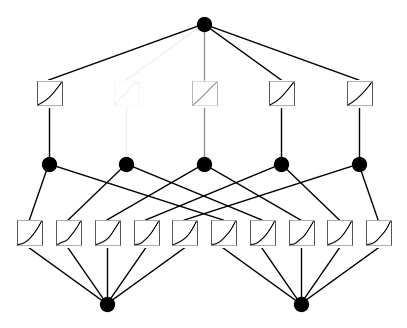

In [41]:
# 绘制初始化时的KAN模型图形
model(dataset['train_input'])
# 使用 plot 方法绘制模型的输出结果
# 设置 beta 参数为 100，用于控制平滑度
model.plot(beta=100)

### 4.使用稀疏正则化训练 KAN 模型

In [42]:
# 对模型进行训练
# 使用 LBFGS 优化器
# 进行 20 步训练
# 设置正则化参数为 0.01
# 设置信息熵正则化参数为 10.0
# 在给定的设备上进行训练
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.,device=device)

train loss: 1.22e-01 | test loss: 1.11e-01 | reg: 1.89e+01 : 100%|██| 20/20 [00:14<00:00,  1.36it/s]


{'train_loss': [array(0.17774457),
  array(0.1649384),
  array(0.13739218),
  array(0.12844005),
  array(0.12625518),
  array(0.13579312),
  array(0.12902339),
  array(0.12892272),
  array(0.12651465),
  array(0.12267715),
  array(0.12234461),
  array(0.12158098),
  array(0.12153054),
  array(0.12159392),
  array(0.12190735),
  array(0.12203006),
  array(0.12210499),
  array(0.12218641),
  array(0.12202529),
  array(0.1219473)],
 'test_loss': [array(0.1680343),
  array(0.15144043),
  array(0.1188317),
  array(0.11041944),
  array(0.11736412),
  array(0.12754529),
  array(0.11984469),
  array(0.12004567),
  array(0.11717632),
  array(0.11198748),
  array(0.11151643),
  array(0.11048052),
  array(0.11041521),
  array(0.1104983),
  array(0.1109166),
  array(0.1110628),
  array(0.11116022),
  array(0.11126267),
  array(0.11104261),
  array(0.11093857)],
 'reg': [array(51.92453039),
  array(29.7866107),
  array(21.74755223),
  array(20.69949648),
  array(20.04275557),
  array(19.7303089),
 

### 5.符号化训练后的KAN网络

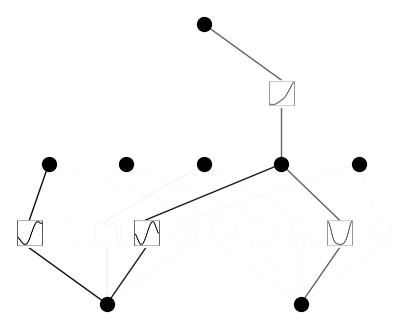

In [43]:
model.plot() # 使用 plot 方法绘制训练后的KAN模型

### 6.剪枝，再绘制（保持原网络结构）

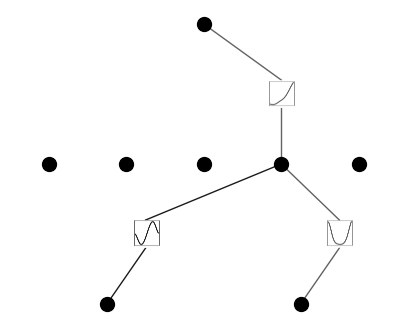

In [44]:
# 对KAN模型进行修剪
model.prune()
# 使用 plot 方法绘制修剪后的KAN模型
# 设置 mask=True 以保持原始形状
model.plot(mask=True)

### 7.剪枝，再绘制（得到更小的网络结构）

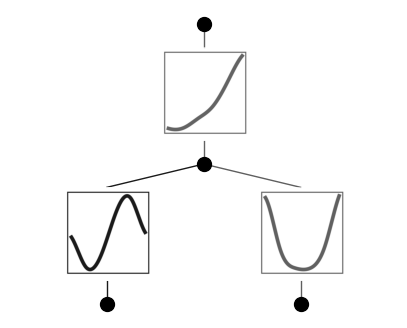

In [45]:
# 修剪KAN模型，并将修剪后的模型重新赋值给原来的模型变量
model = model.prune()
# 使用修剪后的模型对训练输入数据进行预测
model(dataset['train_input'])
# 使用 plot 方法绘制修剪后的KAN模型的输出结果
model.plot()

### 8.继续训练

In [46]:
# 继续对模型进行训练
# 使用 LBFGS 优化器
# 进行 50 步训练
# 在给定的设备上进行训练
model.train(dataset, opt="LBFGS", steps=50,device=device);

train loss: 4.71e-03 | test loss: 4.74e-03 | reg: 2.85e+00 : 100%|██| 50/50 [00:19<00:00,  2.62it/s]


### 9.绘制

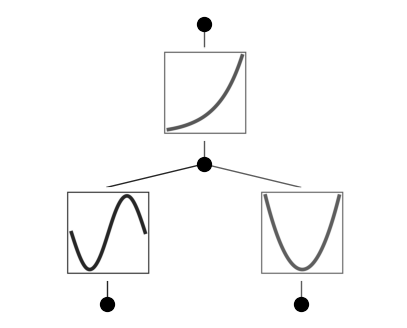

In [47]:
model.plot() # 使用 plot 方法绘制模型的输出结果

### 10.自动或手动设置激活函数为符号函数

In [48]:
# 设置 mode 变量为 "auto" 或 "manual"，以确定激活函数的设置方式
mode = "auto"  # 或者 mode = "manual"
# 如果 mode 是 "manual"，则手动设置激活函数为符号函数
if mode == "manual":
    # 手动模式下，逐个指定隐藏层和输入层的激活函数
    # 第一个参数表示层的索引，第二个和第三个参数表示神经元的索引
    # 第四个参数为要设置的激活函数，例如 'sin', 'x^2', 'exp' 等
    model.fix_symbolic(0,0,0,'sin'); # 设置第一个隐藏层的第一个神经元的激活函数为正弦函数
    model.fix_symbolic(0,1,0,'x^2'); # 设置第一个隐藏层的第二个神经元的激活函数为平方函数
    model.fix_symbolic(1,0,0,'exp'); # 设置输出层的第一个神经元的激活函数为指数函数
# 如果 mode 是 "auto"，则自动设置激活函数为符号函数
elif mode == "auto":
    # 自动模式下，根据提供的激活函数库自动选择合适的符号函数作为激活函数
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9999872981947846
fixing (0,1,0) with x^2, r2=0.9999995774611793
fixing (1,0,0) with exp, r2=0.9999989642148466


### 11.继续训练达到机器精度

In [49]:
model.train(dataset, opt="LBFGS",steps=50,device=device); # 继续对模型进行训练

train loss: 7.45e-10 | test loss: 7.64e-10 | reg: 2.85e+00 : 100%|██| 50/50 [00:06<00:00,  8.14it/s]


### 12.得到数学表达式

In [50]:
model.symbolic_formula()[0][0] # 获取模型的符号化公式

# f(x,y) = exp(sin(pi*x)+y^2)
# 几乎完美复现

1.0*exp(1.0*x_2**2 + 1.0*sin(3.14*x_1))